In [1]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

In [2]:
from evrp.utils.utilities import create_optimal_edges, create_json_out, update_instance_json, read_instance_json_str, convert_txt_instances_to_csv, trace_routes
from evrp.utils.plot import plot_interactive_graph, plot_evrptwv2g
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np

import json

pd.options.plotting.backend = "plotly"

# Convert Schneider instance to E-VRP-TW-V2G

In [292]:
schneider_instance = 'rc105C5'
convert_txt_instances_to_csv(schneider_instance)

 # Full solve

Objective options: {Schneider} OR {OpEx CapEx Cycle EA DCM Delivery}

Constraint options: {Start=End, FullStart=End, NoXkappaBounds, NoMinVehicles, NoSymmetry, NoXd, SplitXp, StationaryEVs}

In [3]:
instance = 'rc105C5_'
fpath = 'config/test_instances/' + instance + '.csv'

In [4]:
m = EVRPTW(problem_type='Schneider Cycle splitxp hull')
m.full_solve(fpath)

2021-07-20 11:07:40 INFO     Building abstract model
2021-07-20 11:07:40 INFO     Defining parameters and sets
2021-07-20 11:07:40 INFO     Defining variables
2021-07-20 11:07:40 INFO     Defining constraints
2021-07-20 11:07:40 INFO     Importing EVRPTW MILP instance: rc105C5_
2021-07-20 11:07:40 INFO     Reading CSV
2021-07-20 11:07:41 INFO     Creating graph
2021-07-20 11:07:41 INFO     Creating timeseries data
2021-07-20 11:07:41 INFO     Creating duplicates and extended graph
2021-07-20 11:07:41 INFO     NumExpr defaulting to 8 threads.
2021-07-20 11:07:41 INFO     Using Scipy euclidian distances to generate distance matrix
2021-07-20 11:07:41 INFO     Calculating distance matrix
2021-07-20 11:07:41 INFO     Creating parameters
2021-07-20 11:07:41 INFO     Creating instance
2021-07-20 11:08:08 INFO     Problem type: Schneider Cycle splitxp hull


KeyError: "Cannot treat the scalar component '_pyomo_gdp_hull_reformulation_1.relaxedDisjuncts[0].disaggregatedVars.'xgamma_station[S0_0,D1].xkappa_station[0].binary_indicator_var'' as an indexed component"

In [360]:
for k, v in m.instance.xkappa.get_values().items():
    if v>0:
        print(k)

('S3_0', 78)
('S3_0', 79)
('S3_0', 80)
('S3_0', 81)
('S3_0', 82)
('S3_0', 83)
('S3_0', 84)
('S3_0', 85)
('S3_0', 86)
('S3_0', 87)
('S3_0', 89)
('S3_0', 90)
('S3_0', 91)
('S3_0', 93)
('S3_0', 94)
('S3_0', 95)
('S3_0', 96)
('S9_0', 42)
('S9_0', 43)
('S9_0', 44)
('S9_0', 45)
('S9_0', 46)
('S9_0', 54)
('S9_0', 55)
('S9_0', 56)
('S9_0', 57)
('S9_0', 60)
('S9_0', 61)
('S9_0', 62)
('S9_0', 65)
('S9_0', 66)
('S9_0', 67)
('S9_0', 68)
('S9_0', 70)
('S9_0', 71)
('S9_0', 72)
('S9_0', 74)
('S15_0', 181)
('S15_0', 182)
('S15_0', 183)
('S15_0', 184)
('S15_0', 185)
('S15_0', 199)
('S15_0', 202)
('S15_0', 203)
('S15_0', 204)
('S15_0', 208)


In [355]:
print(m.results)


Problem: 
- Name: x38632
  Lower bound: 1224.7819328565424
  Upper bound: 2241.296391876728
  Number of objectives: 1
  Number of constraints: 142832
  Number of variables: 20392
  Number of binary variables: 18434
  Number of integer variables: 18434
  Number of continuous variables: 1958
  Number of nonzeros: 779849
  Sense: minimize
Solver: 
- Status: aborted
  Return code: 0
  Message: Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.
  Termination condition: maxTimeLimit
  Termination message: Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.
  Wall time: 120.24764609336853
  Error rc: 0
  Time: 124.28939604759216
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [356]:
for k, v in m.instance.xgamma_station_disjunction.items():
    print(k)
    for d in v.disjuncts:
        if d.indicator_var.value>0:
            print(d)
            if d.name.split('[')[0] != 'xgamma_station_off':
                for kk, vv in d.xkappa_station.items():
                    if vv.indicator_var.value>0:
                        print(kk)

S0_0
xgamma_station[S0_0,C36]
S3_0
xgamma_station[S3_0,C82]
78
79
80
81
82
83
84
85
86
87
89
90
91
93
94
95
96
S9_0
xgamma_station[S9_0,C11]
42
43
44
45
46
54
55
56
57
60
61
62
65
66
67
68
70
71
72
74
S15_0
xgamma_station[S15_0,D1]
181
182
183
184
185
199
202
203
204
208


2021-07-02 10:30:13 WARNING  3


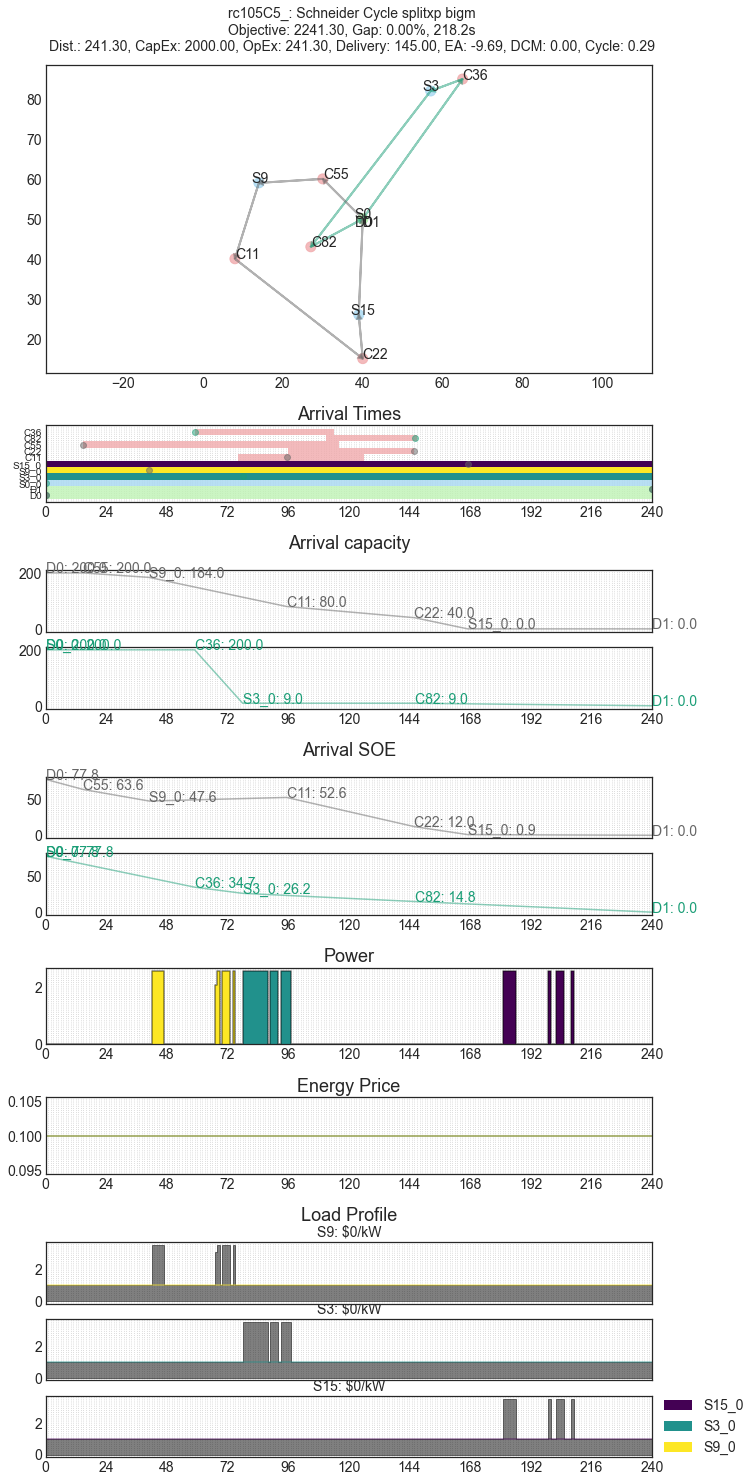

In [361]:
x, xp, traces, routes = plot_evrptwv2g(m, save=False)

In [348]:
rr = trace_routes(m)[0]
EMAX = m.p[None]['EMAX'][None]
running_e = EMAX
for i in range(len(rr)-1):
    print(rr[i], rr[i+1])
    print(m.data['d'].loc[rr[i],rr[i+1]])
    running_e -= m.data['d'].loc[rr[i],rr[i+1]]
    print(running_e)

D0 C55
14.142135623730951
63.60786437626905
C55 S9_0
16.0312195418814
47.57664483438765
S9_0 C11
19.924858845171276
27.651785989216375
C11 C22
40.607881008493905
-12.95609501927753
C22 D1
35.0
-47.95609501927753


In [351]:
e = 47.1
for k, v in m.instance.xp.get_values().items():
    if k[0] == 'S9_0':
        if v>0:
            e += v
            print(k[1], v, e)

54 2.5641025641158106 49.664102564115815
55 2.564102564102564 52.22820512821838
56 2.564102564102564 54.79230769232094
57 2.564102564102564 57.3564102564235
58 2.564102564102564 59.92051282052606
59 2.564102564102564 62.484615384628626
60 2.564102564102564 65.0487179487312
61 2.564102564102564 67.61282051283376
62 2.564102564102564 70.17692307693633
63 2.564102564102564 72.7410256410389
64 2.564102564102564 75.30512820514147
65 2.564102564102564 77.86923076924404
66 2.564102564102564 80.43333333334661
67 2.564102564102564 82.99743589744918
68 2.564102564102564 85.56153846155175
69 2.564102564102564 88.12564102565432
70 2.564102564102564 90.68974358975689
71 2.564102564102564 93.25384615385946
72 2.564102564102564 95.81794871796203
73 2.564102564102564 98.3820512820646
74 2.564102564102564 100.94615384616716


In [344]:
m.instance.xp.get_values()

{('S0_0', 0): 0.0,
 ('S0_0', 1): 0.0,
 ('S0_0', 2): 0.0,
 ('S0_0', 3): 0.0,
 ('S0_0', 4): 0.0,
 ('S0_0', 5): 0.0,
 ('S0_0', 6): 0.0,
 ('S0_0', 7): 0.0,
 ('S0_0', 8): 0.0,
 ('S0_0', 9): 0.0,
 ('S0_0', 10): 0.0,
 ('S0_0', 11): 0.0,
 ('S0_0', 12): 0.0,
 ('S0_0', 13): 0.0,
 ('S0_0', 14): 0.0,
 ('S0_0', 15): 0.0,
 ('S0_0', 16): 0.0,
 ('S0_0', 17): 0.0,
 ('S0_0', 18): 0.0,
 ('S0_0', 19): 0.0,
 ('S0_0', 20): 0.0,
 ('S0_0', 21): 0.0,
 ('S0_0', 22): 0.0,
 ('S0_0', 23): 0.0,
 ('S0_0', 24): 0.0,
 ('S0_0', 25): 0.0,
 ('S0_0', 26): 0.0,
 ('S0_0', 27): 0.0,
 ('S0_0', 28): 0.0,
 ('S0_0', 29): 0.0,
 ('S0_0', 30): 0.0,
 ('S0_0', 31): 0.0,
 ('S0_0', 32): 0.0,
 ('S0_0', 33): 0.0,
 ('S0_0', 34): 0.0,
 ('S0_0', 35): 0.0,
 ('S0_0', 36): 0.0,
 ('S0_0', 37): 0.0,
 ('S0_0', 38): 0.0,
 ('S0_0', 39): 0.0,
 ('S0_0', 40): 0.0,
 ('S0_0', 41): 0.0,
 ('S0_0', 42): 0.0,
 ('S0_0', 43): 0.0,
 ('S0_0', 44): 0.0,
 ('S0_0', 45): 0.0,
 ('S0_0', 46): 0.0,
 ('S0_0', 47): 0.0,
 ('S0_0', 48): 0.0,
 ('S0_0', 49): 0.0,
 ('S0_0', 

In [352]:
m.instance.constraint_energy_soe_station.pprint()

constraint_energy_soe_station : Size=960, Index=constraint_energy_soe_station_index, Active=True


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [335]:
dfs = []
for k, v in {'xp': m.instance.xp, 'xc': m.instance.xc, 'xg': m.instance.xg}.items():
    dfs.append(pd.DataFrame.from_dict(data=v.get_values(), orient='index', columns=[k]))
df = pd.concat(dfs, axis=1)
df[(df>0).any(axis=1)]

,xp,xc,xg
"(S3_0, 80)",2.564103,2.564103,0.0
"(S3_0, 81)",2.564103,2.564103,0.0
"(S3_0, 82)",2.564103,2.564103,0.0
"(S3_0, 83)",2.564103,2.564103,0.0
"(S3_0, 84)",2.564103,2.564103,0.0
"(S3_0, 85)",2.564103,2.564103,0.0
"(S3_0, 86)",2.564103,2.564103,0.0
"(S3_0, 87)",2.564103,2.564103,0.0
"(S3_0, 88)",2.564103,2.564103,0.0
"(S3_0, 89)",2.564103,2.564103,0.0


In [ ]:
routes

In [326]:
trace_routes(m)[0]

('D0', 'C55', 'S9_0', 'C11', 'C22', 'D1')

In [ ]:
m.data['d']

# Archive, fix route, modify objective, and warmstart solve

In [ ]:
m.archive_instance_result()

In [ ]:
m.fix_variables(['xgamma'])

In [ ]:
m.remake_objective(m.instance, 'Opex Capex EA DCM cycle')

In [ ]:
m.warmstart_solve()

In [ ]:
print(m.results)

In [ ]:
x, xp, traces, routes = plot_evrptwv2g(m)

# Archive, rebuild model to modify constraints, fix route, warmstart solve

In [ ]:
m.archive_instance_result()

In [ ]:
m.instance_archive

In [ ]:
m.remake_model('Opex Capex EA DCM cycle wsplitxgamma', fpath)

In [ ]:
m.set_xgamma('Opex Capex EA DCM cycle')

In [ ]:
m.fix_variables(['xgamma'])

In [ ]:
m.make_solver(solve_options={'TimeLimit': 60 * 5})

In [ ]:
m.warmstart_solve()

In [ ]:
x, xp, traces, routes = plot_evrptwv2g(m)

In [ ]:
routes

# Check infeasible constraints

In [ ]:
from pyomo.util.infeasible import log_infeasible_constraints

In [ ]:
log_infeasible_constraints(m.instance)